自制 小个子法式优雅气质轻复古光泽感短款芥末绿吊带


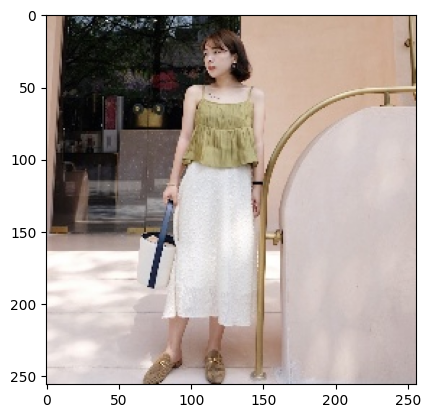

In [1]:
import pandas as pd 
from PIL import Image 
import matplotlib.pyplot as plt 
import os 


# 读取数据
df_train = pd.read_csv('./data/dataset/train.csv')
df_test_image = pd.read_csv('./data/dataset/test_candidate_image.csv')
df_test_text = pd.read_csv('./data/dataset/test_candidate_text.csv')

for image_name in df_train['image_name'][: 1]:
    img_path = os.path.join('./data/dataset/images', image_name)
    # 需要将图片左右翻转，这样才能调正
    text = df_train.loc[df_train['image_name']==image_name, 'text'].values[0]
    print(text)
    img = Image.open(img_path).transpose(Image.FLIP_LEFT_RIGHT)
    plt.imshow(img)
    plt.show()

In [2]:
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import os
import torch 


device = "cuda" if torch.cuda.is_available() else "cpu"
# 设置镜像端点
os.environ["HF_ENDPOINT"] = "https://huggingface.co"
os.environ["TRANSFORMERS_CACHE"] = "hf-mirror"
model = ChineseCLIPModel.from_pretrained("OFA-Sys/chinese-clip-vit-huge-patch14", cache_dir="./").to(device)
processor = ChineseCLIPProcessor.from_pretrained("OFA-Sys/chinese-clip-vit-huge-patch14", cache_dir="./")

2024-08-27 01:17:38.380686: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 01:17:38.469798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 01:17:40.060788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and wil

In [3]:
from peft import get_peft_model, LoraConfig
import torch 
import transformers


# 只微调qkv
target_modules = []
for i in range(24):
    target_modules.append(f"text_model.encoder.layer.{i}.attention.self.query")
    target_modules.append(f"text_model.encoder.layer.{i}.attention.self.key")
    target_modules.append(f"text_model.encoder.layer.{i}.attention.self.value")
    
for i in range(32):
    target_modules.append(f"vision_model.emcoder.layers.{i}.self_attn.k_proj")
    target_modules.append(f"vision_model.emcoder.layers.{i}.self_attn.v_proj")
    target_modules.append(f"vision_model.emcoder.layers.{i}.self_attn.q_proj")

# LoRA配置
lora_config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules=target_modules
)

# 将 LoRA 应用于模型
lora_model = get_peft_model(model, lora_config)

In [4]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import torch 
import numpy as np 

df_train = pd.read_csv('./data/dataset/train.csv')
# df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
img_path = "./data/dataset/images"
df_train["image_path"] = df_train["image_name"].apply(lambda x: os.path.join(img_path, x))
# df_valid["image_path"] = df_valid["image_name"].apply(lambda x: os.path.join(img_path, x))
# print(df_train.shape, df_valid.shape)
train_dataset = Dataset.from_pandas(df_train)
# valid_dataset = Dataset.from_pandas(df_valid)

In [ ]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from peft import PeftModel
import logging

# 配置 logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("training(all_data_625).log"),
        logging.StreamHandler()
    ]
)

# 定义优化器
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=4e-5)
# 定义批量
batch_size = 625
# 定义dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

# 训练模型的自定义循环
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    progress_bar = tqdm(dataloader, desc="Training", leave=False, dynamic_ncols=True)
    
    for batch in progress_bar:
        # 将数据移动到GPU
        images = []
        for image_path in batch["image_path"]:
            try:
                images.append(Image.open(image_path).transpose(Image.FLIP_LEFT_RIGHT).convert("RGB"))
            except:
                images.append(Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8)).convert("RGB"))
        inputs = processor(text=batch["text"], images=images, return_tensors="pt", padding=True, truncation=True, max_length=52).to(device)
        outputs = model(**inputs)
        logits_per_image = outputs["logits_per_image"]
        logits_per_text = outputs["logits_per_text"]
        labels = torch.arange(logits_per_image.size(0), device=device)
        # 计算损失
        loss_text = F.cross_entropy(logits_per_text, labels)
        loss_image = F.cross_entropy(logits_per_image, labels)
        loss = (loss_text + loss_image) / 2
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # 保存预测和标签
        preds = torch.argmax(logits_per_text, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, acc

def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False, dynamic_ncols=True)
    
    with torch.no_grad():
        for batch in progress_bar:
            # 将数据移动到GPU
            images = []
            for image_path in batch["image_path"]:
                try:
                    images.append(Image.open(image_path).convert("RGB"))
                except:
                    images.append(Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8)).transpose(Image.FLIP_LEFT_RIGHT).convert("RGB"))
            inputs = processor(text=batch["text"], images=images, return_tensors="pt", padding=True, truncation=True, max_length=52).to(device)
            outputs = model(**inputs)
            logits_per_image = outputs["logits_per_image"]
            logits_per_text = outputs["logits_per_text"]
            labels = torch.arange(logits_per_image.size(0), device=device)
            # 计算损失
            loss_text = F.cross_entropy(logits_per_text, labels)
            loss_image = F.cross_entropy(logits_per_image, labels)
            loss = (loss_text + loss_image) / 2
            total_loss += loss.item()
            # 保存预测和标签
            preds = torch.argmax(logits_per_text, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())
            progress_bar.set_postfix(loss=loss.item())
    
        avg_loss = total_loss / len(dataloader)
        acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, acc

# 设置Epoch
num_epochs = 30
# 设置设备为GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device)
logging.info(f"Epoch 0/{num_epochs}")
valid_loss, valid_acc = evaluate_epoch(lora_model, train_dataloader, device)
logging.info(f"Training Loss: {valid_loss}, Acc: {valid_acc}")
# 训练循环
for epoch in range(num_epochs):
    logging.info(f"Epoch {epoch + 1}/{num_epochs}")
    # 训练一个epoch
    train_loss, train_acc = train_epoch(lora_model, train_dataloader, optimizer, device)
    logging.info(f"Training Loss: {train_loss}, Acc: {train_acc}")
    
    # # 在验证集上评估
    # valid_loss, valid_acc = evaluate_epoch(lora_model, valid_dataloader, device)
    # logging.info(f"Validation Loss: {valid_loss}, Acc: {valid_acc}")
    # lora_model.save_pretrained(f"./adapter/adapter_{epoch+1}")

2024-08-27 01:18:01,265 [INFO] Epoch 0/30


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)


In [ ]:
torch.save(lora_model, 'lora_model_all_data_625.pth')

In [ ]:
from datasets import Dataset


lora_model.eval()
dataset_test_image = Dataset.from_pandas(df_test_image)
def get_image_embed(batch):
    with torch.no_grad():
        image_paths = [os.path.join('./data/dataset/images', image_name) for image_name in batch["image_name"]]
        images = [Image.open(image_path).transpose(Image.FLIP_LEFT_RIGHT).convert("RGB") for image_path in image_paths]
        pixel_values = processor(text=None, images=images, return_tensors="pt")["pixel_values"].to(device)
        image_embeds = lora_model.get_image_features(pixel_values)
        batch["image_embeds"] = image_embeds
        return batch
dataset_test_image = dataset_test_image.map(get_image_embed, batched=True, batch_size=256)

In [ ]:
dataset_test_text = Dataset.from_pandas(df_test_text)
def get_text_embed(batch):
    with torch.no_grad():
        inputs = processor(text=batch["text"], images=None, return_tensors="pt", padding=True, truncation=True, max_length=52).to(device)
        text_embeds = lora_model.get_text_features(**inputs)
        batch["text_embeds"] = text_embeds
        return batch
dataset_test_text = dataset_test_text.map(get_text_embed, batched=True, batch_size=512)

In [ ]:
dataset_test_text.set_format("torch", columns=["text_embeds"])
dataset_test_image.set_format("torch", columns=["image_embeds"])
image_embeddings = dataset_test_image["image_embeds"].to(device)
text_embeddings = dataset_test_text["text_embeds"].to(device)
image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

In [ ]:
# 匈牙利算法
similar_matrix = torch.mm(text_embeddings, image_embeddings.T).detach().cpu().numpy()

In [ ]:
# 动态规划的匹配（匈牙利算法）
import numpy as np
from scipy.optimize import linear_sum_assignment


# 使用匈牙利算法找到最佳匹配
row_ind, col_ind = linear_sum_assignment(similar_matrix, maximize=True)

# 输出匹配结果
matches = list(zip(row_ind, col_ind))
total_similarity = similar_matrix[row_ind, col_ind].sum()

print(f"Total similarity: {total_similarity}")
print(f"Matches: {matches}")

In [19]:
image_name_all = []
for line in matches:
    image_idx = line[1]
    image_name = df_test_image['image_name'].values[image_idx]
    image_name_all.append(image_name)

df_submit = pd.read_csv('./data/sample_submit.csv')
df_submit['image_name'] = image_name_all
df_submit.to_csv('./clip_h_14_lora_25_all_model_匈牙利算法.csv', index=False)